# This script uses a one-tailed Fisher's exact test to estimate the power of demonstrating RNS success

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import os
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Try one set of p_szr p_stop parameters
n_subs=20
n_subs_per_group=int(n_subs/2)
n_sim=10000
p_szr=0.5
p_stop=1.0
p_combo=p_szr*(1-p_stop)
n_szrs_stim_group=np.zeros(n_sim)
n_szrs_control_group=np.zeros(n_sim)
reject_null=np.zeros(n_sim)
p_fisher=np.zeros(n_sim)
p_t=np.zeros(n_sim)
for sim_ct in range(n_sim):
    n_szrs_stim_group[sim_ct]=np.random.binomial(n_subs_per_group,p_combo)
    n_szrs_control_group[sim_ct]=np.random.binomial(n_subs_per_group,p_szr)
    oddsratio, pvalue = stats.fisher_exact([[n_szrs_stim_group[sim_ct], n_subs_per_group-n_szrs_stim_group[sim_ct]], 
                                            [n_szrs_control_group[sim_ct], n_subs_per_group-n_szrs_control_group[sim_ct]]],alternative='less')
    reject_null[sim_ct]=pvalue<0.05
    p_fisher[sim_ct]=pvalue
    
    # Ind samp t-test (not as appropriate, but should be similar with enough patients)
    temp_stim=np.zeros(n_subs_per_group)
    temp_ctrl=np.zeros(n_subs_per_group)
    temp_stim[:int(n_szrs_stim_group[sim_ct])]=1
    temp_ctrl[:int(n_szrs_control_group[sim_ct])]=1
    t, p_t[sim_ct]=scipy.stats.ttest_ind(temp_stim, temp_ctrl) #NOTE THIS IS ONE TAILED!!!

reject_null_t=p_t<0.05
print('Stim group: mean (SD) # of szrs: %f (%f)' % (np.mean(n_szrs_stim_group),np.std(n_szrs_stim_group)))
print('Control group: mean (SD) # of szrs: %f (%f)' % (np.mean(n_szrs_control_group),np.std(n_szrs_control_group)))
print('Fisher Power (SE): %f (%f)' % (np.mean(reject_null),np.std(reject_null)/np.sqrt(n_sim)))
print('t Power (SE): %f (%f)' % (np.mean(reject_null_t),np.std(reject_null_t)/np.sqrt(n_sim)))

/Users/davidgroppe/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:3851: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


Stim group: mean (SD) # of szrs: 0.000000 (0.000000)
Control group: mean (SD) # of szrs: 5.019500 (1.566499)
Fisher Power (SE): 0.833900 (0.003722)
t Power (SE): 0.833900 (0.003722)


/Users/davidgroppe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in less


In [10]:
# Try multiple sets of p_szr p_stop parameters
n_subs=80
n_subs_per_group=int(n_subs/2)
n_sim=5000
dlt=0.1 # step size between different probabilities
try_p=np.arange(0,1+dlt,dlt)
n_p=len(try_p)
pwr_fisher=np.zeros((n_p,n_p))
pwr_t=np.zeros((n_p,n_p)) # I did a t-test too, just to double check fisher results
for p_szr_ct, p_szr in enumerate(try_p):
    for p_stop_ct, p_stop in enumerate(try_p):
        p_combo=p_szr*(1-p_stop)
        p_fisher=np.zeros(n_sim)
        p_t=np.zeros(n_sim)
        n_szrs_stim_group=np.zeros(n_sim)
        n_szrs_control_group=np.zeros(n_sim)
        for sim_ct in range(n_sim):
            n_szrs_stim_group[sim_ct]=np.random.binomial(n_subs_per_group,p_combo)
            n_szrs_control_group[sim_ct]=np.random.binomial(n_subs_per_group,p_szr)
            oddsratio, pvalue = stats.fisher_exact([[n_szrs_stim_group[sim_ct], n_subs_per_group-n_szrs_stim_group[sim_ct]], 
                                            [n_szrs_control_group[sim_ct], n_subs_per_group-n_szrs_control_group[sim_ct]]],alternative='less')
            p_fisher[sim_ct]=pvalue
    
            # Ind samp t-test (not as appropriate, but should be similar with enough patients)
            temp_stim=np.zeros(n_subs_per_group)
            temp_ctrl=np.zeros(n_subs_per_group)
            temp_stim[:int(n_szrs_stim_group[sim_ct])]=1
            temp_ctrl[:int(n_szrs_control_group[sim_ct])]=1
            t, p_t[sim_ct]=scipy.stats.ttest_ind(temp_stim, temp_ctrl) #NOTE THIS IS TWO TAILED!!!
            
        pwr_fisher[p_szr_ct,p_stop_ct]=np.mean(p_fisher<.05)
        # For testing plotting code
#         if p_szr_ct==0:
#             pwr_fisher[p_szr_ct,p_stop_ct]=1
        pwr_t[p_szr_ct,p_stop_ct]=np.mean(p_t<.05)

print('Done')

/Users/davidgroppe/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:3851: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail
/Users/davidgroppe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less


Done


Writing file 40_per_group.pdf


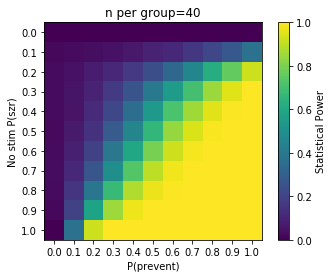

In [11]:
plt.figure()
plt.imshow(pwr_fisher)
plt.colorbar(label='Statistical Power')
ticks=np.arange(0,11,1)
plt.xticks(ticks,try_p)
plt.yticks(ticks,try_p)
plt.ylabel('No stim P(szr)')
plt.xlabel('P(prevent)')
plt.title('n per group='+str(n_subs_per_group))
#out_fname=str(n_subs_per_group)+'_per_group.png'
out_fname=str(n_subs_per_group)+'_per_group.pdf'
plt.savefig(out_fname)
print('Writing file %s' % out_fname)

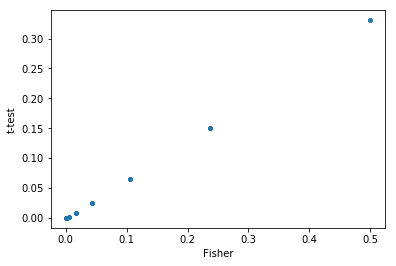

In [57]:
plt.figure()
plt.plot(p_fisher,p_t,'.')
plt.xlabel('Fisher')
plt.ylabel('t-test')

In [27]:
oddsratio, pvalue = stats.fisher_exact([[1,11],
                                        [9,3]])
print(pvalue)

0.00275945618522


In [28]:
oddsratio, pvalue = stats.fisher_exact([[1,9],
                                        [11,3]])
print(pvalue)

0.00275945618522


In [65]:
# Example from Zar
# Zar gets a p-value of 0.019
# MATLAB gets a p-value of 0.0212
oddsratio, pvalue = stats.fisher_exact([[12,7],
                                        [2,9]],alternative='greater')
print(pvalue)

0.0211894052974


In [66]:
oddsratio, pvalue = stats.fisher_exact([[12,7],
                                        [2,9]])
print(pvalue)

0.0258870564718


In [54]:
stats.fisher_exact?